In [12]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import os
from sklearn.cluster import FeatureAgglomeration
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.datasets import make_classification
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import plotly.express as px

import string
import re

# FeatureAgglomeration Reduction + KNN Test

In [13]:
# Load the spotify keys and data, and perform some basic data preprocessing

load_dotenv()
SPOTIFY_KEY1 = '798c070d2d5e4ab98b36353e469dba19' # To prevent the need for authentification, we will change this once semester is over
SPOTIFY_KEY2 = 'ec5f36a15c864212a84ab03d15fc7c74'
SPOTIFY_DATA = os.getenv('SPOTIFY_DATA')

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(SPOTIFY_KEY1,SPOTIFY_KEY2))

df_spotify = pd.read_csv(SPOTIFY_DATA)

print(f"Shape of Dataset: {df_spotify.shape}")

num_duplicate_rows = df_spotify.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {num_duplicate_rows}")

any_null_values = df_spotify.isnull().any()
print(f"\nAny Null Values in DataFrame: \n{any_null_values}")

Shape of Dataset: (170653, 19)

Number of Duplicate Rows: 0

Any Null Values in DataFrame: 
valence             False
year                False
acousticness        False
artists             False
danceability        False
duration_ms         False
energy              False
explicit            False
id                  False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
name                False
popularity          False
release_date        False
speechiness         False
tempo               False
dtype: bool


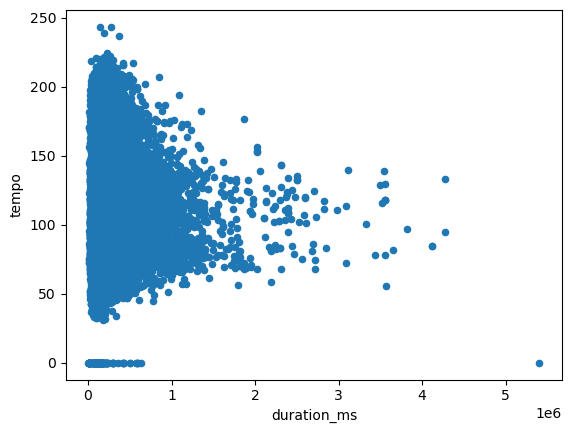

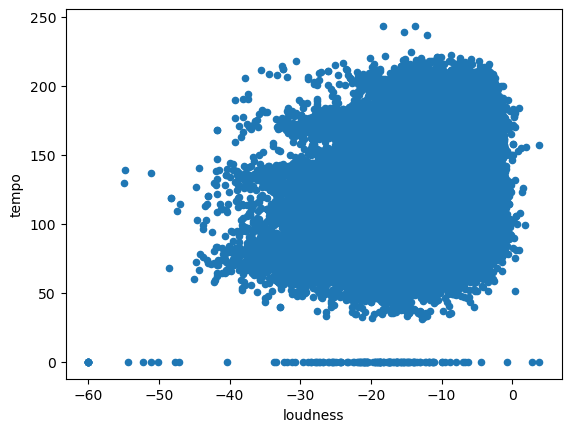

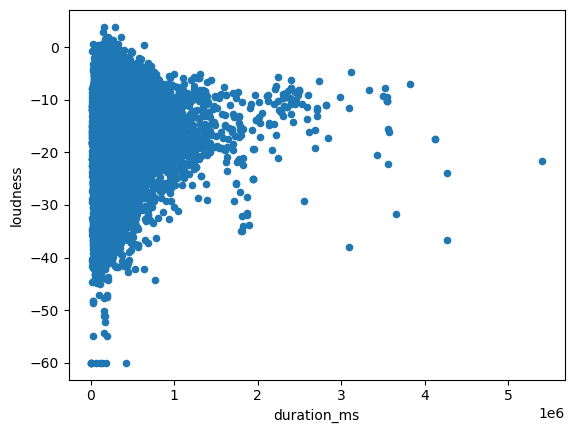

In [31]:
# Checking of any potential patterns for non-discrete value columns, for the purposes of project report.
df_report1 = df_spotify[['duration_ms', 'tempo']]
df_report2 = df_spotify[['loudness', 'tempo']]
df_report3 = df_spotify[['duration_ms', 'loudness']]
#print(df_report.head(10))

df_report1.plot(kind='scatter', x='duration_ms', y='tempo')
plt.show()

df_report2.plot(kind='scatter', x='loudness', y='tempo')
plt.show()

df_report3.plot(kind='scatter', x='duration_ms', y='loudness')
plt.show()

In [14]:
# Drop the columns which arent found in the audio features we will be extracting from the spotify song

df_relevant_columns = df_spotify.drop(columns=['id','name','release_date','year','artists', 'popularity','explicit'], axis=1)
display(df_relevant_columns.head(10))

,valence,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,0.0594,0.982,0.279,831667,0.211,0.878000,10,0.665,-20.096,1,0.0366,80.954
1,0.9630,0.732,0.819,180533,0.341,0.000000,7,0.160,-12.441,1,0.4150,60.936
2,0.0394,0.961,0.328,500062,0.166,0.913000,3,0.101,-14.850,1,0.0339,110.339
3,0.1650,0.967,0.275,210000,0.309,0.000028,5,0.381,-9.316,1,0.0354,100.109
4,0.2530,0.957,0.418,166693,0.193,0.000002,3,0.229,-10.096,1,0.0380,101.665
5,0.1960,0.579,0.697,395076,0.346,0.168000,2,0.130,-12.506,1,0.0700,119.824
6,0.4060,0.996,0.518,159507,0.203,0.000000,0,0.115,-10.589,1,0.0615,66.221
7,0.0731,0.993,0.389,218773,0.088,0.527000,1,0.363,-21.091,0,0.0456,92.867
8,0.7210,0.996,0.485,161520,0.130,0.151000,5,0.104,-21.508,0,0.0483,64.678
9,0.7710,0.982,0.684,196560,0.257,0.000000,8,0.504,-16.415,1,0.3990,109.378


In [15]:
# print_info taken from Alan/main.py
def print_info(track):
    print('\nArtist: ' + track['artists'][0]['name'])
    print('Track: ' + track['name'])
    print('Album: ' + track['album']['name'])
    AP = track['preview_url']
    if AP is None:
        print("No Audio Preview available")
    else:
        print('Audio Preview: ' + track['preview_url'])
    print('Cover Art: ' + track['album']['images'][0]['url'])

# Get the spotify song audio features to use as input, and drop features we wont be using

found = False
while not found:
    track_id = input("Enter uri: ")
    if spotify.track(track_id):
        found = True

track = spotify.track(track_id)
print_info(track)

artist_name = track['artists'][0]['name']
song_name = track['name']
song_features = spotify.audio_features(track_id)

df_song = pd.DataFrame(song_features)
df_song = df_song.drop(columns=['track_href','analysis_url','type','id','uri','time_signature'])
display(df_song)

song_df_reorder = ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']

df_song = df_song[song_df_reorder]

display(df_song)


Artist: Lena Raine
Track: First Steps
Album: Celeste (Original Soundtrack)
Audio Preview: https://p.scdn.co/mp3-preview/5ffd1e4c21d1b9cab50652893ae8135079e6e59f?cid=798c070d2d5e4ab98b36353e469dba19
Cover Art: https://i.scdn.co/image/ab67616d0000b273b351fafcb334009c3216a039


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.545,0.635,0,-7.874,1,0.0259,0.379,0.0579,0.158,0.0884,90.005,218708


,valence,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,0.0884,0.379,0.545,218708,0.635,0.0579,0,0.158,-7.874,1,0.0259,90.005


In [37]:
# Scale the dataset and the song input to improve unit variance and model convergence

standard = StandardScaler()

X_standard = standard.fit_transform(df_relevant_columns)
song_standard = standard.transform(df_song)

df_data_standard = pd.DataFrame(X_standard, columns=df_relevant_columns.columns)
df_song_standard = pd.DataFrame(song_standard, columns=df_relevant_columns.columns)

print(X_standard.shape, "\n")
display(df_data_standard.head(10))
print(song_standard.shape, "\n")
display(df_song_standard)

(170653, 12) 



,valence,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,-1.782825,1.276187,-1.467013,4.763146,-1.013988,2.268102,1.365588,2.626719,-1.514237,0.643912,-0.379706,-1.169307
1,1.650688,0.611347,1.598779,-0.399747,-0.528270,-0.532771,0.512123,-0.262229,-0.170766,0.643912,1.945481,-1.821180
2,-1.858821,1.220340,-1.188820,2.133824,-1.182122,2.379754,-0.625830,-0.599749,-0.593551,0.643912,-0.396297,-0.212404
3,-1.381564,1.236296,-1.489722,-0.166101,-0.647832,-0.532682,-0.056853,1.002043,0.377680,0.643912,-0.387080,-0.545537
4,-1.047180,1.209703,-0.677855,-0.509485,-1.081242,-0.532765,-0.625830,0.132499,0.240788,0.643912,-0.371104,-0.494867
5,-1.263770,0.204465,0.906137,1.301381,-0.509589,0.003159,-0.910318,-0.433849,-0.182173,0.643912,-0.174471,0.096469
6,-0.465809,1.313418,-0.110116,-0.566464,-1.043879,-0.532771,-1.479295,-0.519660,0.154265,0.643912,-0.226701,-1.649077
7,-1.730767,1.305440,-0.842500,-0.096539,-1.473552,1.148391,-1.194806,0.899071,-1.688862,-1.553007,-0.324403,-0.781368
8,0.731133,1.313418,-0.297470,-0.550503,-1.316628,-0.051072,-0.056853,-0.582587,-1.762046,-1.553007,-0.307812,-1.699324
9,0.921124,1.276187,0.832331,-0.272668,-0.842119,-0.532771,0.796611,1.705688,-0.868212,0.643912,1.847164,-0.243698


(1, 12) 



,valence,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,-1.67263,-0.327406,0.043174,-0.097054,0.5702,-0.348066,-1.479295,-0.27367,0.630754,0.643912,-0.445456,-0.874567


In [42]:
# Test out 4 cluster FeatureAgglomeration
agglo_4 = FeatureAgglomeration(n_clusters = 4)

X_agglo_4 = agglo_4.fit_transform(X_standard)
song_agglo_4 = agglo_4.transform(song_standard)

df_data_agglo_4 = pd.DataFrame(X_agglo_4)
df_song_agglo_4 = pd.DataFrame(song_agglo_4)

print(X_agglo_4.shape, "\n")
display(df_data_agglo_4.head(10))
print(song_agglo_4.shape, "\n")
display(df_song_agglo_4)

(170653, 4) 



,0,1,2,3
0,1.803932,-1.232511,1.772144,-1.624919
1,0.487908,-0.840072,0.039288,1.624734
2,0.231172,-0.662692,1.800047,-1.523821
3,0.207184,-0.271896,0.351807,-1.435643
4,-0.146002,-0.445107,0.338469,-0.862518
5,0.085331,-0.198431,0.103812,-0.178816
6,-0.429641,-0.846230,0.390324,-0.287962
7,-0.453937,-1.314594,1.226915,-1.286633
8,-0.610153,-1.592666,0.631173,0.216832
9,0.944142,-0.651343,0.371708,0.876727


(1, 4) 



,0,1,2,3
0,-0.330313,0.108796,-0.337736,-0.814728


In [43]:
# Use the agglomerated data to train the NearestNeighbors (unsupervised KNN) model
knn_model = NearestNeighbors(n_neighbors=5, metric='euclidean', algorithm='ball_tree')
knn_model.fit(X_agglo_4)

NearestNeighbors(algorithm='ball_tree', metric='euclidean')

In [45]:
# Process song input in the same way, and test model with kneighbors query
input_song = df_song[df_relevant_columns.columns]
input_song_scaled = standard.transform(input_song)
print(input_song_scaled)
input_song_agglo = agglo_4.transform(input_song_scaled)
print(input_song_agglo)

distances, indices = knn_model.kneighbors(input_song_agglo)
recommended_songs = df_spotify.iloc[indices.flatten()][['artists', 'name']]

print(recommended_songs)

[[-1.67263006 -0.32740622  0.04317353 -0.0970544   0.57020012 -0.34806608
  -1.47929458 -0.27367002  0.63075405  0.64391197 -0.44545559 -0.87456696]]
[[-0.33031252  0.10879574 -0.33773615 -0.81472826]]
                                     artists  \
70916   ['Jim Brickman', 'Michael W. Smith']   
123421                         ['Autoheart']   
28311                ['The Electric Prunes']   
146041      ['The Montclairs', 'Phil Perry']   
130538                         ['The Dells']   

                                            name  
70916   Love of My Life (feat. Michael W. Smith)  
123421              Hungover in the City of Dust  
28311                               Holy Are You  
146041                  Dreaming's out of Season  
130538                           O-O, I Love You  


# Further Analysis

In [48]:
# Check the which of our columns were grouped into which agglomeration cluster
print(agglo_4.labels_, "\n")

original_feature_indices_4 = []

for cluster_id in range(4):
    cluster_indices = np.where(agglo_4.labels_ == cluster_id)[0]
    original_feature_indices_4.append(df_relevant_columns.columns[cluster_indices])

print(original_feature_indices_4)

# Print the result
for cluster_id, features in enumerate(original_feature_indices_4):
    print(f"Cluster {cluster_id}:  Feature Names {features}")

[3 2 3 0 1 2 0 0 1 0 0 1] 

[Index(['duration_ms', 'key', 'liveness', 'mode', 'speechiness'], dtype='object'), Index(['energy', 'loudness', 'tempo'], dtype='object'), Index(['acousticness', 'instrumentalness'], dtype='object'), Index(['valence', 'danceability'], dtype='object')]
Cluster 0:  Feature Names Index(['duration_ms', 'key', 'liveness', 'mode', 'speechiness'], dtype='object')
Cluster 1:  Feature Names Index(['energy', 'loudness', 'tempo'], dtype='object')
Cluster 2:  Feature Names Index(['acousticness', 'instrumentalness'], dtype='object')
Cluster 3:  Feature Names Index(['valence', 'danceability'], dtype='object')


In [47]:
# Test out 5 cluster FeatureAgglomeration to see if features are better spread out
agglo_5 = FeatureAgglomeration(n_clusters = 5)

X_agglo_5 = agglo_5.fit_transform(X_standard)
song_agglo_5 = agglo_5.transform(song_standard)

df_data_agglo_5 = pd.DataFrame(X_agglo_5)
df_song_agglo_5 = pd.DataFrame(song_agglo_5)

print(X_agglo_5.shape, "\n")
display(df_data_agglo_5.head(10))
print(song_agglo_5.shape, "\n")
display(df_song_agglo_5)

print(agglo_5.labels_, "\n")

original_feature_indices_5 = []

for cluster_id in range(5):
    cluster_indices = np.where(agglo_5.labels_ == cluster_id)[0]
    original_feature_indices_5.append(df_relevant_columns.columns[cluster_indices])

print(original_feature_indices_5)

# Print the result
for cluster_id, features in enumerate(original_feature_indices_5):
    print(f"Cluster {cluster_id}: Original Features {features}")

(170653, 4) 



,0,1,2,3,4
0,2.093937,-1.232511,1.772144,-1.624919,0.643912
1,0.448907,-0.840072,0.039288,1.624734,0.643912
2,0.127987,-0.662692,1.800047,-1.523821,0.643912
3,0.098002,-0.271896,0.351807,-1.435643,0.643912
4,-0.343480,-0.445107,0.338469,-0.862518,0.643912
5,-0.054314,-0.198431,0.103812,-0.178816,0.643912
6,-0.698030,-0.846230,0.390324,-0.287962,0.643912
7,-0.179169,-1.314594,1.226915,-1.286633,-1.553007
8,-0.374439,-1.592666,0.631173,0.216832,-1.553007
9,1.019199,-0.651343,0.371708,0.876727,0.643912


(1, 4) 



,0,1,2,3,4
0,-0.573869,0.108796,-0.337736,-0.814728,0.643912


[3 2 3 0 1 2 0 0 1 4 0 1] 

[Index(['duration_ms', 'key', 'liveness', 'speechiness'], dtype='object'), Index(['energy', 'loudness', 'tempo'], dtype='object'), Index(['acousticness', 'instrumentalness'], dtype='object'), Index(['valence', 'danceability'], dtype='object'), Index(['mode'], dtype='object')]
Cluster 0: Original Features Index(['duration_ms', 'key', 'liveness', 'speechiness'], dtype='object')
Cluster 1: Original Features Index(['energy', 'loudness', 'tempo'], dtype='object')
Cluster 2: Original Features Index(['acousticness', 'instrumentalness'], dtype='object')
Cluster 3: Original Features Index(['valence', 'danceability'], dtype='object')
Cluster 4: Original Features Index(['mode'], dtype='object')


In [54]:
# Remove less significant features and perform 4 cluster FeatureAgglomeration on new set of features
df_new_relevant_columns = df_spotify.drop(columns=['id','name','release_date','year','artists', 'popularity','explicit', 'duration_ms', 'key', 'liveness', 'speechiness', 'mode'], axis=1)
display(df_new_relevant_columns.head(10))
input_song_new = df_song[df_new_relevant_columns.columns]
display(input_song_new)

standard = StandardScaler()

X_standard_new = standard.fit_transform(df_new_relevant_columns)
song_standard_new = standard.transform(input_song_new)

agglo_4_new = FeatureAgglomeration(n_clusters = 4)

X_agglo_4_new = agglo_4_new.fit_transform(X_standard_new)
song_agglo_4_new = agglo_4_new.transform(song_standard_new)

df_data_agglo_4_new = pd.DataFrame(X_agglo_4_new)
df_song_agglo_4_new = pd.DataFrame(song_agglo_4_new)

print(X_agglo_4_new.shape, "\n")
display(df_data_agglo_4_new.head(10))
print(song_agglo_4_new.shape, "\n")
display(df_song_agglo_4_new)

print(agglo_4_new.labels_, "\n")

original_feature_indices_4_new = []

for cluster_id in range(4):
    cluster_indices = np.where(agglo_4_new.labels_ == cluster_id)[0]
    original_feature_indices_4_new.append(df_new_relevant_columns.columns[cluster_indices])

print(original_feature_indices_4_new)

# Print the result
for cluster_id, features in enumerate(original_feature_indices_4_new):
    print(f"Cluster {cluster_id}: Original Features {features}")

# End result is a more balanced spread of features among our 4 clusters, so we will be using this version of feature reduction

,valence,acousticness,danceability,energy,instrumentalness,loudness,tempo
0,0.0594,0.982,0.279,0.211,0.878000,-20.096,80.954
1,0.9630,0.732,0.819,0.341,0.000000,-12.441,60.936
2,0.0394,0.961,0.328,0.166,0.913000,-14.850,110.339
3,0.1650,0.967,0.275,0.309,0.000028,-9.316,100.109
4,0.2530,0.957,0.418,0.193,0.000002,-10.096,101.665
5,0.1960,0.579,0.697,0.346,0.168000,-12.506,119.824
6,0.4060,0.996,0.518,0.203,0.000000,-10.589,66.221
7,0.0731,0.993,0.389,0.088,0.527000,-21.091,92.867
8,0.7210,0.996,0.485,0.130,0.151000,-21.508,64.678
9,0.7710,0.982,0.684,0.257,0.000000,-16.415,109.378


,valence,acousticness,danceability,energy,instrumentalness,loudness,tempo
0,0.0884,0.379,0.545,0.635,0.0579,-7.874,90.005


(170653, 4) 



,0,1,2,3
0,1.772144,-1.264113,-1.624919,-1.169307
1,0.039288,-0.349518,1.624734,-1.821180
2,1.800047,-0.887836,-1.523821,-0.212404
3,0.351807,-0.135076,-1.435643,-0.545537
4,0.338469,-0.420227,-0.862518,-0.494867
5,0.103812,-0.345881,-0.178816,0.096469
6,0.390324,-0.444807,-0.287962,-1.649077
7,1.226915,-1.581207,-1.286633,-0.781368
8,0.631173,-1.539337,0.216832,-1.699324
9,0.371708,-0.855166,0.876727,-0.243698


(1, 4) 



,0,1,2,3
0,-0.337736,0.600477,-0.814728,-0.874567


[2 0 2 1 0 1 3] 

[Index(['acousticness', 'instrumentalness'], dtype='object'), Index(['energy', 'loudness'], dtype='object'), Index(['valence', 'danceability'], dtype='object'), Index(['tempo'], dtype='object')]
Cluster 0: Original Features Index(['acousticness', 'instrumentalness'], dtype='object')
Cluster 1: Original Features Index(['energy', 'loudness'], dtype='object')
Cluster 2: Original Features Index(['valence', 'danceability'], dtype='object')
Cluster 3: Original Features Index(['tempo'], dtype='object')
